Set Up, load files


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import pandas as pd
from collections import defaultdict
import numpy as np
from numpy import unravel_index

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_annotated_vcfs

HG01975_k21.deeppolisher.annotated_fixed_fp_kmers.vcf
HG01975_k21.deeppolisher.annotated_induced_fp_kmers.vcf
HG01975_k31.deeppolisher.annotated_fixed_fp_kmers.vcf
HG01975_k31.deeppolisher.annotated_induced_fp_kmers.vcf
HG01993_k21.deeppolisher.annotated_fixed_fp_kmers.vcf
HG01993_k21.deeppolisher.annotated_induced_fp_kmers.vcf
HG01993_k31.deeppolisher.annotated_fixed_fp_kmers.vcf
HG01993_k31.deeppolisher.annotated_induced_fp_kmers.vcf
HG02129_k21.deeppolisher.annotated_fixed_fp_kmers.vcf
HG02129_k21.deeppolisher.annotated_induced_fp_kmers.vcf
HG02129_k31.deeppolisher.annotated_fixed_fp_kmers.vcf
HG02129_k31.deeppolisher.annotated_induced_fp_kmers.vcf
HG04115.deeppolisher.annotated_fixed_fp_kmers.vcf
HG04115.deeppolisher.annotated_induced_fp_kmers.vcf
HG04115_hybrid_k21.deeppolisher.annotated_fixed_fp_kmers.vcf
HG04115_hybrid_k21.deeppolisher.annotated_induced_fp_kmers.vcf
HG04115_hybrid_k31.deeppolisher.annotated_fixed_fp_kmers.vcf
HG04115_hybrid_k31.deeppolisher.annotated_induced_fp_

Parse vcfs per sample

In [ ]:
def parse_vcf(vcf_path):
  records = []
  with open(vcf_path, "r") as f:
    for line in f:
      # skip header lines
      if line.startswith("#"): continue
      cols = line.strip().split()
      records.append(cols)
  return records

In [ ]:
samples = ["HG01993_k21", "HG02129_k21", "HG01975_k21", "HG04115_k21", "HG01993_k31", "HG02129_k31", "HG01975_k31", "HG04115_k31"]
samples_k21=["HG01993_k21", "HG02129_k21", "HG01975_k21", "HG04115_k21"]
samples_k31=["HG01993_k31", "HG02129_k31", "HG01975_k31", "HG04115_k31"]
vcf_dict = {}
base_path = "/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_annotated_vcfs"
for sample in samples:
  vcf_dict[sample] = {}
  vcf_dict[sample]["fixed"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_fixed_fp_kmers.vcf")
  vcf_dict[sample]["induced"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_induced_fp_kmers.vcf")

In [ ]:
vcf_dict["HG01993_k21"]["fixed"][0]

['h1tg000001l',
 '627361',
 '.',
 'A',
 'AGATCATGAAATGGAAATTGG',
 '18',
 'PASS',
 '.',
 'GT:GQ',
 '0/1:18',
 'h1tg000001l',
 '627341',
 '627380',
 '19']

In [ ]:
def get_q_count(kmer_vcf, only_insertion_one = False):
  kmer_q_count = np.zeros(40) # list containing number of kmers overlapping edits at GQ values from 0 to 40
  blocks = set()
  for rec in kmer_vcf:
    block = (rec[10], rec[11], rec[12]) # get FP kmer block
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    if block in blocks: continue
    q = int(rec[5]) # GQ value at each record
    kmer_count = int(rec[13]) # number of FP kmers in the given block
    len_rec = len(rec[4]) - len(rec[3]) # edit length
    # if the edit was 1bp insertion
    # and only_insertion_one was True
    if len_rec == 1 and only_insertion_one:
      kmer_q_count[q] += kmer_count
    elif only_insertion_one == False:
      kmer_q_count[q] += kmer_count
    blocks.add(block)
  return kmer_q_count

In [ ]:
def get_q_count_del(kmer_vcf, only_deletion_one = False):
  kmer_q_count = np.zeros(40) # list containing number of kmers overlapping edits at GQ values from 0 to 40
  blocks = set()
  for rec in kmer_vcf:
    block = (rec[10], rec[11], rec[12]) # get FP kmer block
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    if block in blocks: continue
    q = int(rec[5]) # GQ value at each record
    kmer_count = int(rec[13]) # number of FP kmers in the given block
    len_rec = len(rec[4]) - len(rec[3]) # edit length
    # if the edit was 1bp insertion
    # and only_insertion_one was True
    if len_rec == -1 and only_deletion_one:
      kmer_q_count[q] += kmer_count
    elif only_deletion_one == False:
      kmer_q_count[q] += kmer_count
    blocks.add(block)
  return kmer_q_count

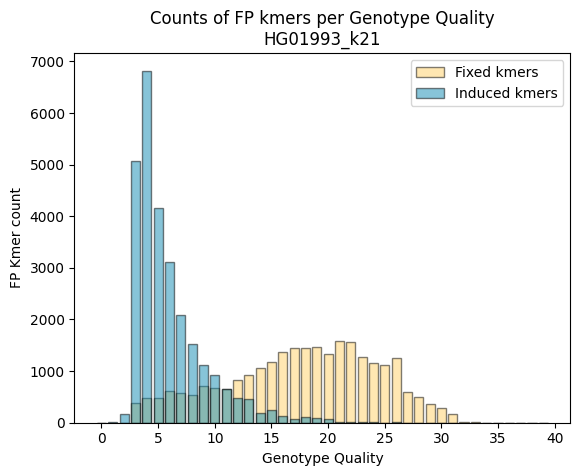

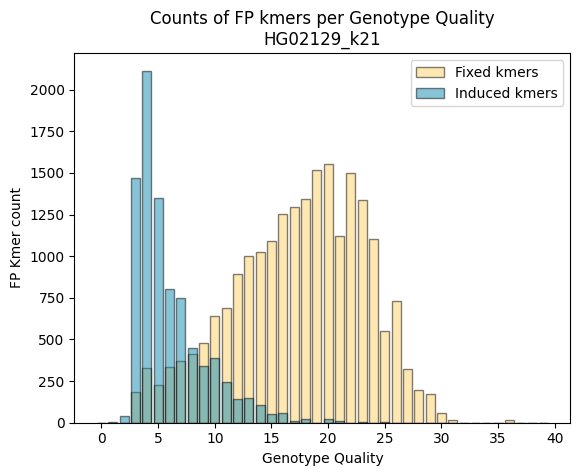

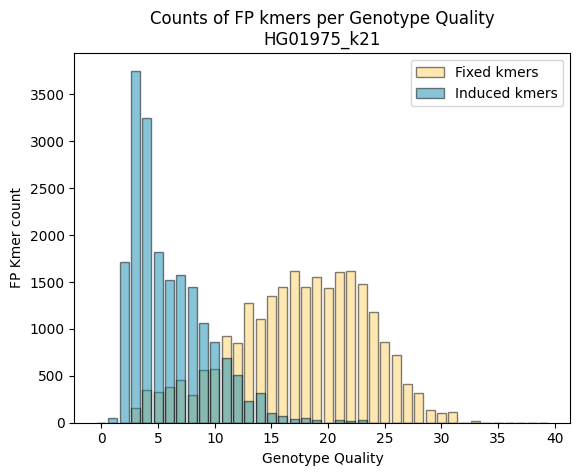

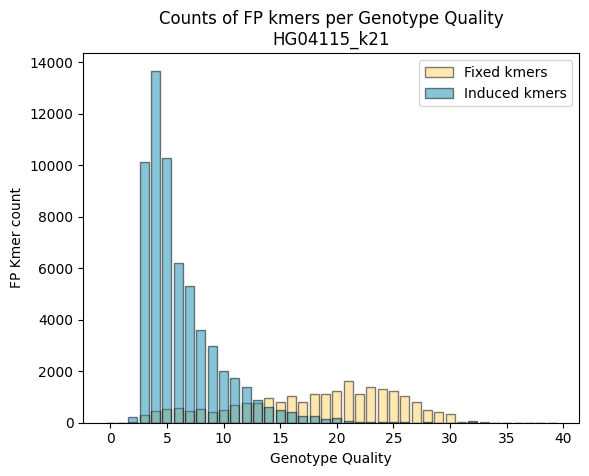

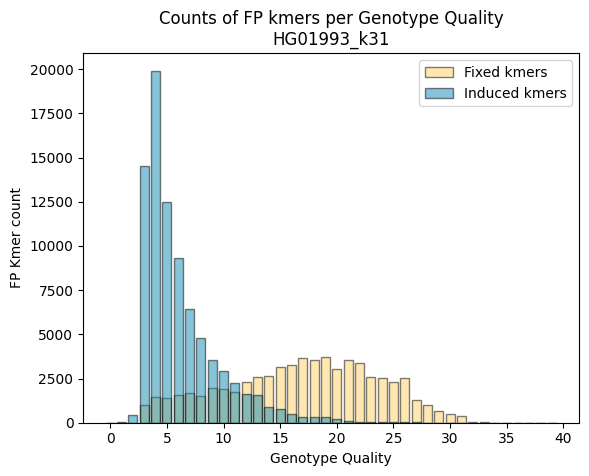

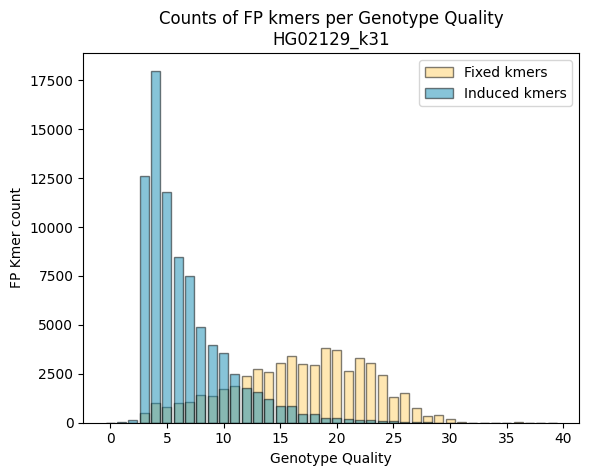

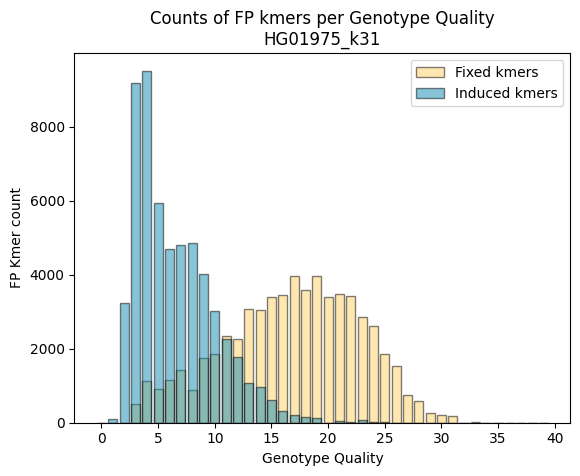

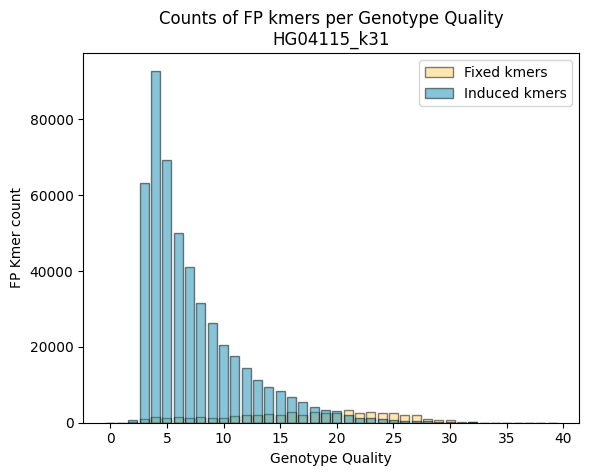

In [ ]:
for sample in samples:
  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  # Plotting a basic histogram
  plt.bar(np.arange(40), fixed_kmer_q_count,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(40), induced_kmer_q_count, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\n{sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()


  #outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_GQ_plots/" + sample + ".all_edits.png"
 #plt.savefig(outPNG,dpi=600)
  plt.show()


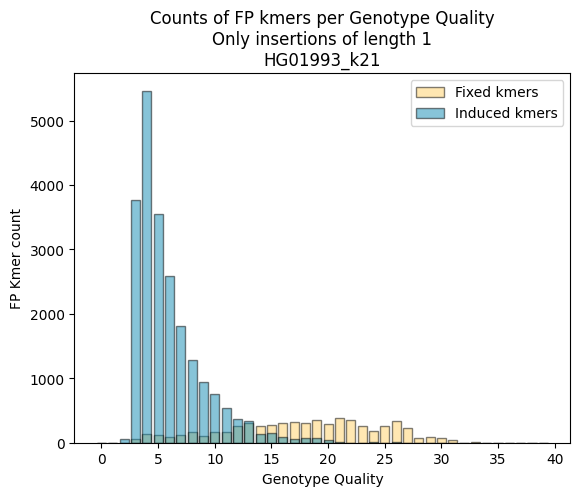

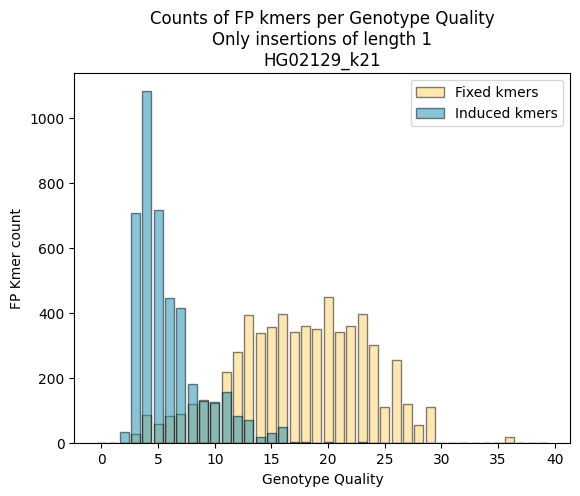

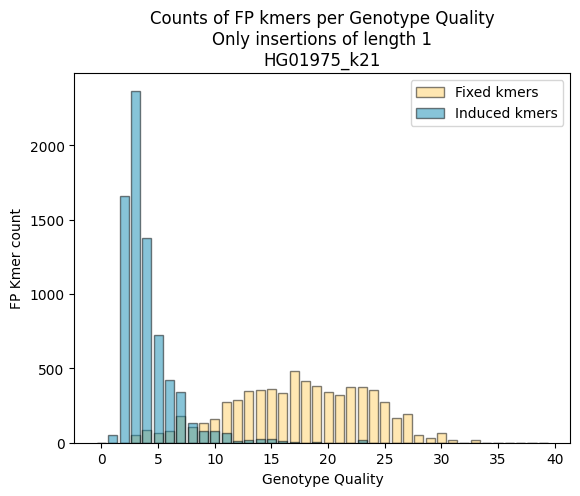

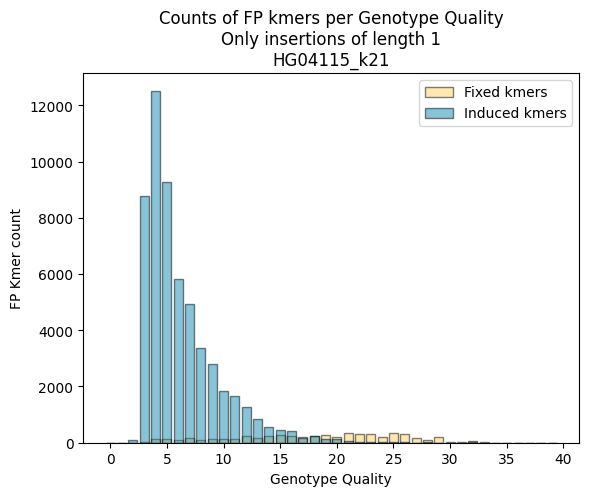

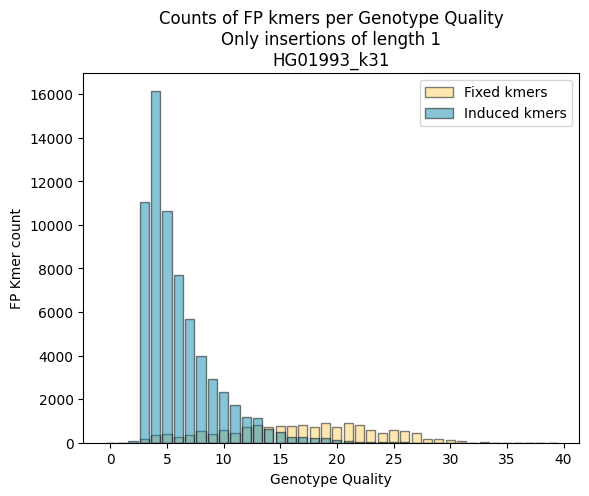

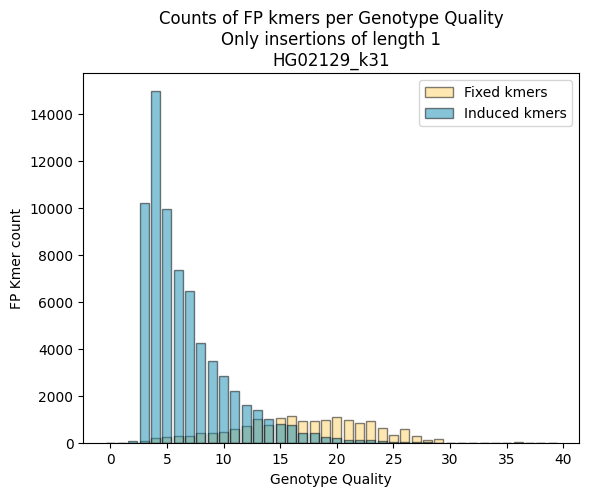

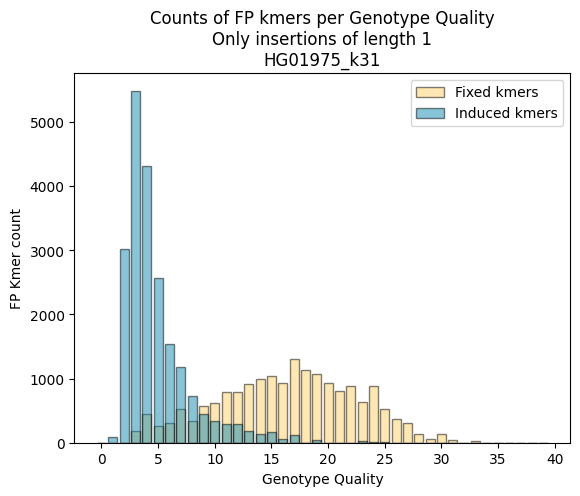

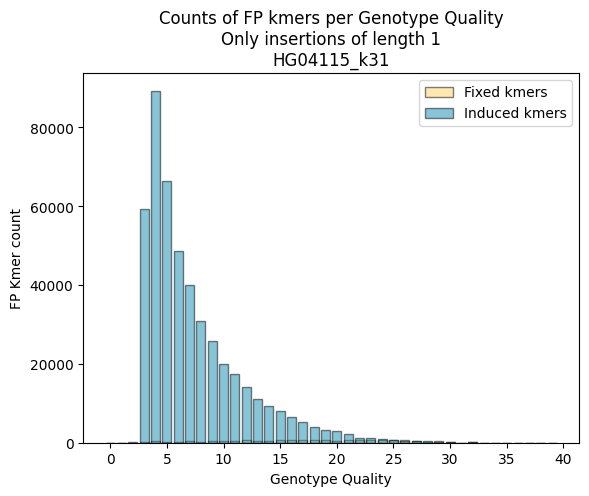

In [ ]:
for sample in samples:
  fixed_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = True)
  induced_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = True)

  plt.bar(np.arange(40), fixed_kmer_q_count_only_ins_one,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(40), induced_kmer_q_count_only_ins_one, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\nOnly insertions of length 1\n{sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()

 # outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_GQ_plots/" + sample + ".only_ins1.png"
  #plt.savefig(outPNG,dpi=600)

  plt.show()



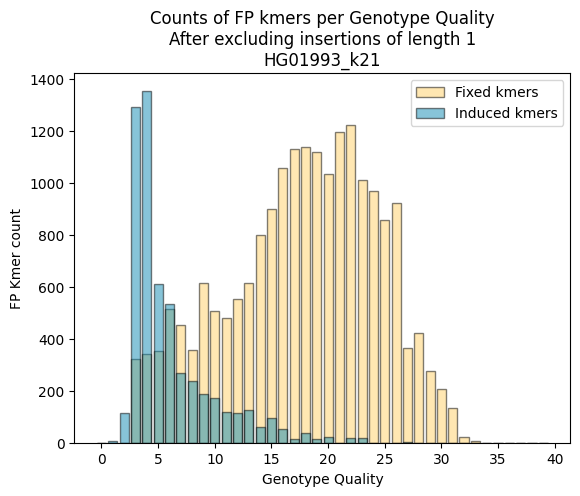

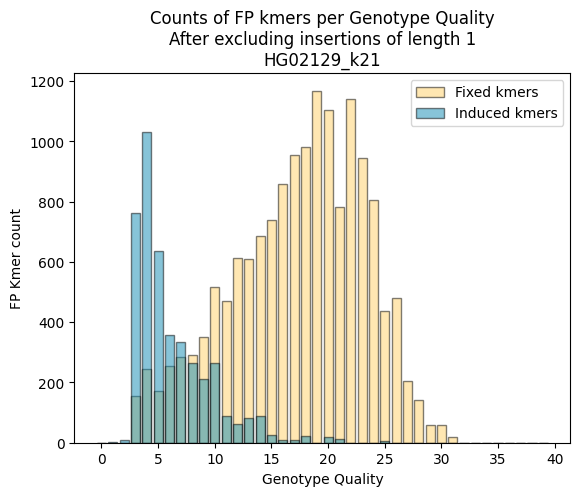

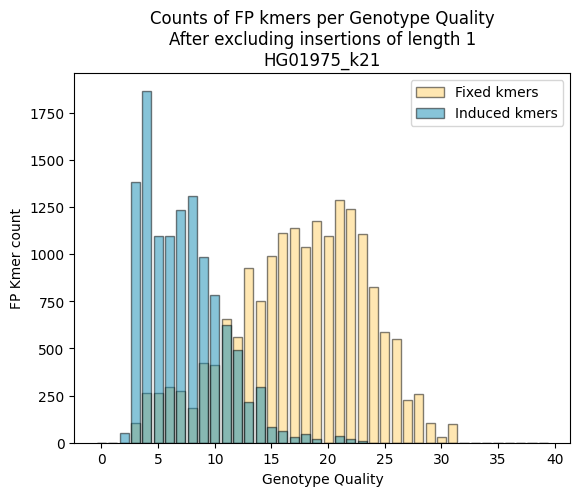

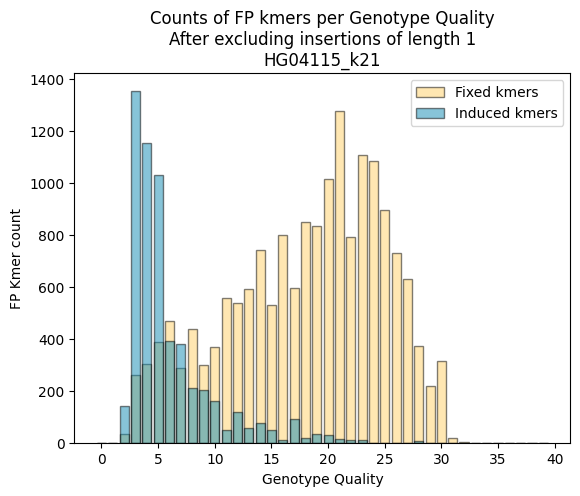

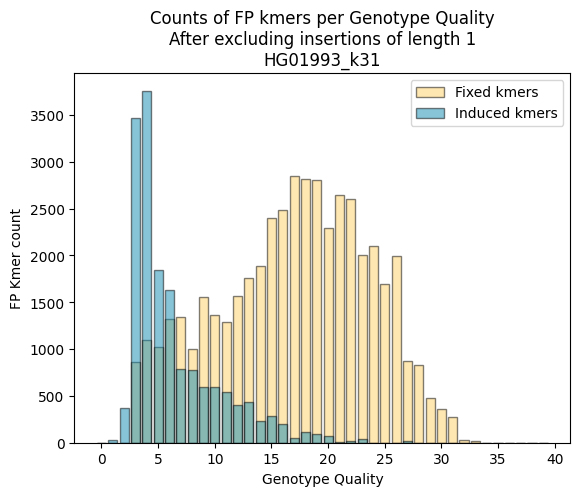

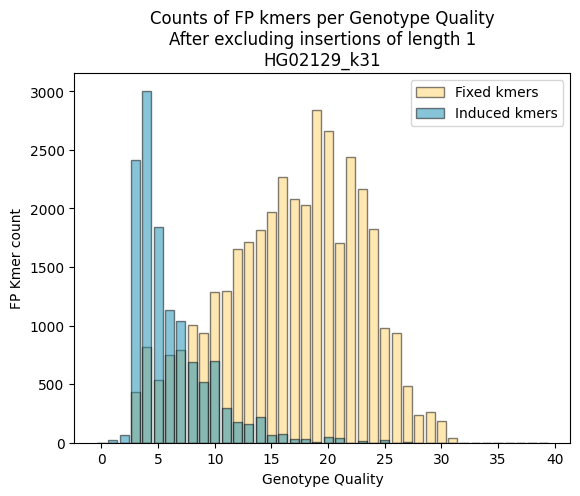

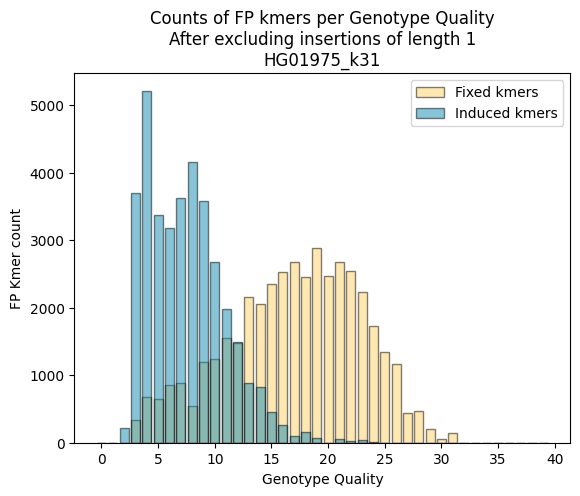

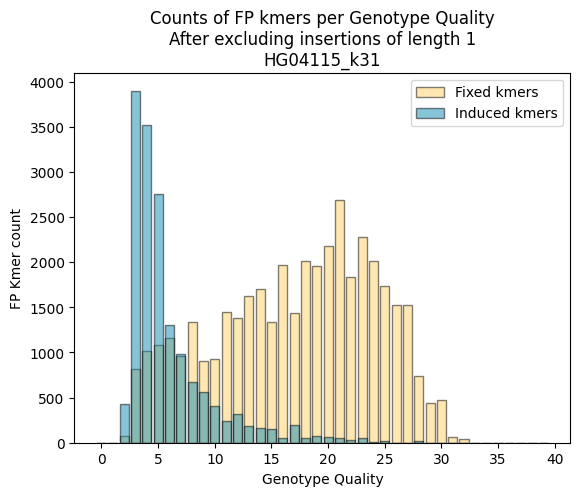

In [ ]:
for sample in samples:
  fixed_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = True)
  induced_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = True)

  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  fixed_kmer_q_count_remaining =  fixed_kmer_q_count - fixed_kmer_q_count_only_ins_one
  induced_kmer_q_count_remaining = induced_kmer_q_count - induced_kmer_q_count_only_ins_one


  plt.bar(np.arange(40), fixed_kmer_q_count_remaining,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(40), induced_kmer_q_count_remaining, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\nAfter excluding insertions of length 1\n{sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()

  #outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_GQ_plots/" + sample + ".exclude_ins1.png"
  #plt.savefig(outPNG,dpi=600)

  plt.show()



In [ ]:
# read in list of # raw FP kmers in each sample

raw_FP_kmer_counts={}

with open(base_path + "/raw_fp_kmer_counts.csv") as kmer_csv:
  for line in kmer_csv:
    sample=line.strip().split(",")[0]
    count=int(line.strip().split(",")[1])
    raw_FP_kmer_counts[sample]=count

print(raw_FP_kmer_counts)

{'HG01975_k21': 95972, 'HG01993_k21': 95499, 'HG04115_k21': 83423, 'HG02129_k21': 69880, 'HG01975_k31': 456262, 'HG01993_k31': 446618, 'HG04115_k31': 388229, 'HG02129_k31': 324323}


In [ ]:
# Get fixed and induced kmer blocks

def get_fixed_induced_kmer_records(sample,vcf_dict):
  fixed_kmer_records = []
  blocks = set()
  for rec in vcf_dict[sample]["fixed"]:
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    fixed_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  induced_kmer_records = []
  blocks = set()
  for rec in vcf_dict[sample]["induced"]:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    induced_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  return fixed_kmer_records,induced_kmer_records

In [ ]:
# For each sample, get the single best GQ threshold

optimal_vals={}

for sample in samples:

  # get fixed and induced kmer records
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  # get the best single GQ threshold
  qv_changes = []
  total_kmer_count = raw_FP_kmer_counts[sample] # before polishing

  for q in range(0,35):
    a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
    b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])
    #print(q,a,b)
    qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)
    qv_changes.append(qv_change)
  optimal_qv=max(qv_changes)
  optimal_gq=np.argmax(qv_changes)

  optimal_vals[sample]=[optimal_gq,optimal_qv]

print(optimal_vals)

{'HG01993_k21': [11, 0.9627494573682445], 'HG02129_k21': [8, 1.3233489585964284], 'HG01975_k21': [10, 0.9824473942885545], 'HG04115_k21': [13, 0.8171977492651987], 'HG01993_k31': [11, 0.4273970814703093], 'HG02129_k31': [11, 0.5029485215181266], 'HG01975_k31': [10, 0.42598070045074465], 'HG04115_k31': [20, 0.14550902365220272]}


In [ ]:
# Take average of optimal GQ filters for k_21 and recalculate QV improvement for each sample
print("QV changes after using optimal GQ filter for each sample: ")

k_21_optimals=[]
k_31_optimals=[]

for sample in samples_k21:
  k_21_optimals.append(optimal_vals[sample][0])
  print(sample, optimal_vals[sample][1],optimal_vals[sample][0] )

k_21_avg_optimal=int(sum(k_21_optimals) / len (k_21_optimals))

print("average of optimal GQ filter for each sample: ", k_21_avg_optimal )

print("QV changes after using average GQ filter: ")

q_threshold = k_21_avg_optimal

for sample in samples_k21:
  # get fixed and induced kmer records
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q_threshold])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q_threshold])

  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)

  print(sample,qv_change)



QV changes after using optimal GQ filter for each sample: 
HG01993_k21 0.9627494573682445 11
HG02129_k21 1.3233489585964284 8
HG01975_k21 0.9824473942885545 10
HG04115_k21 0.8171977492651987 13
average of optimal GQ filter for each sample:  10
QV changes after using average GQ filter: 
HG01993_k21 0.9622386261848068
HG02129_k21 1.2909350121553842
HG01975_k21 0.9824473942885545
HG04115_k21 0.7071920656959538


In [ ]:
# Take average of optimal GQ filters for k_31 and recalculate QV improvement for each sample
print("QV changes after using optimal GQ filter for each sample: ")

k_31_optimals=[]

for sample in samples_k31:
  k_31_optimals.append(optimal_vals[sample][0])
  print(sample, optimal_vals[sample][1],optimal_vals[sample][0] )

k_31_avg_optimal=int(sum(k_31_optimals) / len (k_31_optimals))

print("average of optimal GQ filter for each sample: ", k_31_avg_optimal )

q_threshold = k_31_avg_optimal

print("QV changes after using average GQ filter: ")
for sample in samples_k31:
  # get fixed and induced kmer records
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q_threshold])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q_threshold])

  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)

  print(sample,qv_change)


QV changes after using optimal GQ filter for each sample: 
HG01993_k31 0.4273970814703093 11
HG02129_k31 0.5029485215181266 11
HG01975_k31 0.42598070045074465 10
HG04115_k31 0.14550902365220272 20
average of optimal GQ filter for each sample:  13
QV changes after using average GQ filter: 
HG01993_k31 0.40937642661995244
HG02129_k31 0.47629835164887624
HG01975_k31 0.3991013703262553
HG04115_k31 -0.11423171114384871


In [ ]:
#for each sample, in k21 find GQ threshold for INS-1 and GQ threshold for the rest
from numpy import unravel_index

ins1_optimals=[]
other_optimals=[]

for sample in samples_k21:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  qv_changes_advanced = np.zeros((15,20))
  total_kmer_count = raw_FP_kmer_counts[sample]
  for q1 in range(10,25):
    for q2 in range(0,20):
      a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
      b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

      a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
      b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

      qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)
      qv_changes_advanced[q1-10][q2-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
  print(f"for {sample} with q1={q1+10} and q2={q2} we get qv change = {max_qv_change}")
  ins1_optimals.append(q1+10)
  other_optimals.append(q2)

avg_ins1_optimal=int(sum(ins1_optimals) / len(ins1_optimals))
avg_other_optimal=int(sum(other_optimals) / len(other_optimals))

print(f"Average INS-1 GQ is {avg_ins1_optimal} and for other variants GQ {avg_other_optimal}")

for HG01993_k21 with q1=13 and q2=6 we get qv change = 1.0522718678944059
for HG02129_k21 with q1=10 and q2=7 we get qv change = 1.3257096671427016
for HG01975_k21 with q1=10 and q2=10 we get qv change = 0.9824473942885545
for HG04115_k21 with q1=16 and q2=7 we get qv change = 0.9873200136842777
Average INS-1 GQ is 12 and for other variants GQ 7


In [ ]:
# calculate new QV improvements using the average GQ cutoffs
q1=12
q2=7

print("using INS-1 GQ cut off of 12, and GQ 7 for the other variants, with k21 we see a QV improvement of:")
for sample in samples_k21:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 12, and GQ 7 for the other variants, with k21 we see a QV improvement of:
HG01993_k21 1.0397738433226305
HG02129_k21 1.303754100595485
HG01975_k21 0.8407239289542944
HG04115_k21 0.9014579630681597


In [ ]:
#for each sample, in k31 find GQ threshold for INS-1 and GQ threshold for the rest
from numpy import unravel_index

ins1_optimals=[]
other_optimals=[]

for sample in samples_k31:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  qv_changes_advanced = np.zeros((15,20))
  total_kmer_count = raw_FP_kmer_counts[sample]
  for q1 in range(10,25):
    for q2 in range(0,20):
      a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
      b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

      a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
      b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

      qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)
      qv_changes_advanced[q1-10][q2-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
  print(f"for {sample} with q1={q1+10} and q2={q2} we get qv change = {max_qv_change}")
  ins1_optimals.append(q1+10)
  other_optimals.append(q2)

avg_ins1_optimal=int(sum(ins1_optimals) / len(ins1_optimals))
avg_other_optimal=int(sum(other_optimals) / len(other_optimals))

print(f"Average INS-1 GQ is {avg_ins1_optimal} and for other variants GQ {avg_other_optimal}")

for HG01993_k31 with q1=13 and q2=6 we get qv change = 0.47111460818327316
for HG02129_k31 with q1=14 and q2=7 we get qv change = 0.5604756192596823
for HG01975_k31 with q1=10 and q2=12 we get qv change = 0.43063446573101205
for HG04115_k31 with q1=24 and q2=7 we get qv change = 0.3814820494018659
Average INS-1 GQ is 15 and for other variants GQ 8


In [ ]:
# calculate new QV improvements using the average GQ cutoffs for k31
q1=15
q2=8

print(f"using INS-1 GQ cut off of {q1}, and {q2} for the other variants, with k31 we see a QV improvement of:")
for sample in samples_k31:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 15, and 8 for the other variants, with k31 we see a QV improvement of:
HG01993_k31 0.4584955485010629
HG02129_k31 0.551572037818076
HG01975_k31 0.3500648401097417
HG04115_k31 0.11844412642130914


In [ ]:
# calculating optimal GQs for each sample for INS-1, DEL-1, and the rest for k21

from numpy import unravel_index

ins1_optimals=[]
del1_optimals=[]
other_optimals=[]

for sample in samples_k21:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  qv_changes_advanced = np.zeros((15,20,25))
  total_kmer_count = raw_FP_kmer_counts[sample]
  for q1 in range(10,25):
    for q2 in range(0,20):
      for q3 in range(0,25):
        a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
        b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

        a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
        b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

        a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
        b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

        qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)
        qv_changes_advanced[q1-10][q2-0][q3-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 , q3 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
  print(f"for {sample} with q1={q1+10} and q2={q2} and q3={q3} we get qv change = {max_qv_change}")
  ins1_optimals.append(q1+10)
  other_optimals.append(q2)
  del1_optimals.append(q3)

avg_ins1_optimal=int(sum(ins1_optimals) / len(ins1_optimals))
avg_other_optimal=int(sum(other_optimals) / len(other_optimals))
avg_del1_optimal=int(sum(del1_optimals) / len(del1_optimals))

print(f"Average INS-1 GQ is {avg_ins1_optimal} , average DEL-1 GQ is {avg_del1_optimal} and for other variants GQ {avg_other_optimal}")

for HG01993_k21 with q1=13 and q2=5 and q3=9 we get qv change = 1.073822681905198
for HG02129_k21 with q1=10 and q2=6 and q3=10 we get qv change = 1.359829926514025
for HG01975_k21 with q1=10 and q2=5 and q3=14 we get qv change = 1.0674177126529174
for HG04115_k21 with q1=16 and q2=5 and q3=10 we get qv change = 1.000474810372641
Average INS-1 GQ is 12 , average DEL-1 GQ is 10 and for other variants GQ 5


In [ ]:
# Calculate QV improvement using the averages
q1=12
q2=5
q3=10

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k21:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 12, DEL-1 GQ cutoff of 10 and 5 for all other variants, with k21 we see a QV improvement of:
HG01993_k21 1.0708538235334357
HG02129_k21 1.3374479335827452
HG01975_k21 0.9947204233751998
HG04115_k21 0.914354854575665


In [ ]:
# calculating optimal GQs for each sample for INS-1, DEL-1, and the rest for k31

from numpy import unravel_index

ins1_optimals=[]
del1_optimals=[]
other_optimals=[]

for sample in samples_k31:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  qv_changes_advanced = np.zeros((15,20,25))
  total_kmer_count = raw_FP_kmer_counts[sample]
  for q1 in range(10,25):
    for q2 in range(0,20):
      for q3 in range(0,25):
        a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
        b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

        a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
        b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

        a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
        b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

        qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)
        qv_changes_advanced[q1-10][q2-0][q3-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 , q3 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
  print(f"for {sample} with q1={q1+10} and q2={q2} and q3={q3} we get qv change = {max_qv_change}")
  ins1_optimals.append(q1+10)
  other_optimals.append(q2)
  del1_optimals.append(q3)

avg_ins1_optimal=int(sum(ins1_optimals) / len(ins1_optimals))
avg_other_optimal=int(sum(other_optimals) / len(other_optimals))
avg_del1_optimal=int(sum(del1_optimals) / len(del1_optimals))

print(f"Average INS-1 GQ is {avg_ins1_optimal} , average DEL-1 GQ is {avg_del1_optimal} and for other variants GQ {avg_other_optimal}")

for HG01993_k31 with q1=13 and q2=5 and q3=11 we get qv change = 0.4810755449362061
for HG02129_k31 with q1=14 and q2=6 and q3=10 we get qv change = 0.5687410714514067
for HG01975_k31 with q1=10 and q2=5 and q3=14 we get qv change = 0.4763117796998631
for HG04115_k31 with q1=24 and q2=5 and q3=7 we get qv change = 0.38430431335220144
Average INS-1 GQ is 15 , average DEL-1 GQ is 10 and for other variants GQ 5


In [ ]:
# Calculate QV improvement using the averages  for k31
q1=15
q2=5
q3=10

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and GQ {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k31:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 15, DEL-1 GQ cutoff of 10 and GQ 5 for all other variants, with k21 we see a QV improvement of:
HG01993_k31 0.47503983146954687
HG02129_k31 0.5632798397031962
HG01975_k31 0.4093185201195174
HG04115_k31 0.12712065198316932


In [ ]:
# Combine FP kmers for all samples, calculate best QV improvements for k21

fixed_kmer_records = []
induced_kmer_records = []
total_kmer_count=0

for sample in samples_k21:

  # get fixed kmer records
  blocks = set()
  for rec in vcf_dict[sample]["fixed"]:
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    fixed_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  # get induced kmer records
  blocks = set()
  for rec in vcf_dict[sample]["induced"]:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    induced_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  total_kmer_count += raw_FP_kmer_counts[sample]

# get the best single GQ threshold
qv_changes = []
for q in range(0,35):
  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])
  #print(q,a,b)
  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)
  qv_changes.append(qv_change)
optimal_single_qv1=max(qv_changes)
optimal_single_gq=np.argmax(qv_changes)

print(f"Combining all FP kmers from all samples, the optimal single GQ threshold is {optimal_single_gq}")

# get the best INS-1, all other variants threshold
qv_changes_advanced = np.zeros((15,20))
for q1 in range(10,25):
  for q2 in range(0,20):
    a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
    b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

    a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
    b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

    qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)
    qv_changes_advanced[q1-10][q2-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)

print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10} and all other variants is {q2}")

# get the best INS-1, DEL-1, and all other variants threshold
qv_changes_advanced = np.zeros((15,20,25))
for q1 in range(10,25):
  for q2 in range(0,20):
    for q3 in range(0,25):
      a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
      b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

      a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
      b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

      a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
      b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

      qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)
      qv_changes_advanced[q1-10][q2-0][q3-0] = qv_change

max_qv_change = max(qv_changes_advanced.flatten())
q1 , q2 , q3 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10}, DEL-1 GQ {q3} and all other variants is {q2}")

Combining all FP kmers from all samples, the optimal single GQ threshold is 11
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 13 and all other variants is 8
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 13, DEL-1 GQ 12 and all other variants is 5


In [ ]:
print(f"For each sample, using a GQ threshold of {optimal_single_gq} we see QV improvement of: ")

q = 11
for sample in samples_k21:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])

  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)

  print(sample,qv_change)

q1=13
q2=8

print(f"using INS-1 GQ cut off of {q1}, and {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k21:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)

  print(sample, qv_change)

q1=13
q2=5
q3=12

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k21:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

For each sample, using a GQ threshold of 11 we see QV improvement of: 
HG01993_k21 0.9627494573682445
HG02129_k21 1.253947323835893
HG01975_k21 0.9688512500729456
HG04115_k21 0.7706343897026755
using INS-1 GQ cut off of 13, and 8 for all other variants, with k21 we see a QV improvement of:
HG01993_k21 1.0345769295686058
HG02129_k21 1.274568264247116
HG01975_k21 0.8846598942835047
HG04115_k21 0.930126915351671
using INS-1 GQ cut off of 13, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k21 we see a QV improvement of:
HG01993_k21 1.071610398644362
HG02129_k21 1.2926922561596608
HG01975_k21 1.0159961299039528
HG04115_k21 0.94433855766593


In [ ]:
# Combine FP kmers for all samples, calculate best QV improvements for k31 now

fixed_kmer_records = []
induced_kmer_records = []
total_kmer_count=0

for sample in samples_k31:

  # get fixed kmer records
  blocks = set()
  for rec in vcf_dict[sample]["fixed"]:
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    fixed_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  # get induced kmer records
  blocks = set()
  for rec in vcf_dict[sample]["induced"]:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q = int(rec[5])
    kmer_count = int(rec[13])
    induced_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  total_kmer_count += raw_FP_kmer_counts[sample]

# get the best single GQ threshold
qv_changes = []
for q in range(0,35):
  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])
  #print(q,a,b)
  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)
  qv_changes.append(qv_change)
optimal_single_qv1=max(qv_changes)
optimal_single_gq=np.argmax(qv_changes)

print(f"Combining all FP kmers from all samples, the optimal single GQ threshold is {optimal_single_gq}")

# get the best INS-1, all other variants threshold
qv_changes_advanced = np.zeros((15,20))
for q1 in range(10,25):
  for q2 in range(0,20):
    a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
    b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

    a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
    b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

    qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)
    qv_changes_advanced[q1-10][q2-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)

print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10} and all other variants is {q2}")

# get the best INS-1, DEL-1, and all other variants threshold
qv_changes_advanced = np.zeros((15,20,25))
for q1 in range(10,25):
  for q2 in range(0,20):
    for q3 in range(0,25):
      a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
      b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

      a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
      b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

      a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
      b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

      qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)
      qv_changes_advanced[q1-10][q2-0][q3-0] = qv_change

max_qv_change = max(qv_changes_advanced.flatten())
q1 , q2 , q3 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10}, DEL-1 GQ {q3} and all other variants is {q2}")

Combining all FP kmers from all samples, the optimal single GQ threshold is 14
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 20 and all other variants is 9
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 20, DEL-1 GQ 12 and all other variants is 5


In [ ]:
print(f"For each sample, using a GQ threshold of {optimal_single_gq} we see QV improvement of: ")

q = 14
for sample in samples_k31:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)
  total_kmer_count = raw_FP_kmer_counts[sample]

  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])

  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a - b))

q1=20
q2=9

print(f"using INS-1 GQ cut off of {q1}, and {q2} for all other variants, with k31 we see a QV improvement of:")

for sample in samples_k31:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a1 + a2 - b1 - b2))

q1=20
q2=5
q3=12

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k31 we see a QV improvement of:")

for sample in samples_k31:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3))

For each sample, using a GQ threshold of 14 we see QV improvement of: 
HG01993_k31 0.39056838527143506 38412
HG02129_k31 0.4558299884349009 32315
HG01975_k31 0.3774512393921392 37980
HG04115_k31 -0.03571682049430954 -3206
using INS-1 GQ cut off of 20, and 9 for all other variants, with k31 we see a QV improvement of:
HG01993_k31 0.41764400915228017 40949
HG02129_k31 0.4993115916908486 35224
HG01975_k31 0.321578858673215 32564
HG04115_k31 0.33555821653011564 28867
using INS-1 GQ cut off of 20, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k31 we see a QV improvement of:
HG01993_k31 0.44571909358643125 43563
HG02129_k31 0.5078978326367081 35795
HG01975_k31 0.38017238935904585 38242
HG04115_k31 0.3422343498580496 29419


In [ ]:
# calculate k=31 improvement using method 1, k=21 optimal filters (INS-1 GQ 13, DEL-1 GQ 12 and all else GQ 5)

q1=13
q2=5
q3=12

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k21:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k31 we see a QV improvement of:")

for sample in samples_k31:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 13, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k21 we see a QV improvement of:
HG01993_k21 1.071610398644362
HG02129_k21 1.2926922561596608
HG01975_k21 1.0159961299039528
HG04115_k21 0.94433855766593
using INS-1 GQ cut off of 13, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k31 we see a QV improvement of:
HG01993_k31 0.48049983632270066
HG02129_k31 0.5544922270585487
HG01975_k31 0.4522879359960583
HG04115_k31 -0.06173401502793939


In [ ]:
# calculate k=21 improvement using method 1, k=31 optimal filters (INS-1 GQ 13, DEL-1 GQ 12 and all else GQ 5)

q1=20
q2=5
q3=12

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k21 we see a QV improvement of:")

for sample in samples_k21:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, with k31 we see a QV improvement of:")
for sample in samples_k31:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample, qv_change)

using INS-1 GQ cut off of 20, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k21 we see a QV improvement of:
HG01993_k21 0.9857422079629298
HG02129_k21 1.0896960069189152
HG01975_k21 0.8702047209539371
HG04115_k21 0.9691912348496358
using INS-1 GQ cut off of 20, DEL-1 GQ cutoff of 12 and 5 for all other variants, with k31 we see a QV improvement of:
HG01993_k31 0.44571909358643125
HG02129_k31 0.5078978326367081
HG01975_k31 0.38017238935904585
HG04115_k31 0.3422343498580496


In [ ]:
def get_edit_length_count(kmer_vcf, max_len):
  kmer_edit_length_count = np.zeros(max_len * 2)
  edit_length_array = np.arange(-max_len,max_len)
  blocks= set()
  for rec in kmer_vcf:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    kmer_count = int(rec[13])
    len_rec = len(rec[4]) - len(rec[3])
    # if the length was larger than max_len
    # add their counts to the rightmost or leftmost bar
    if len_rec >= max_len: len_rec = max_len - 1
    if len_rec <= -max_len: len_rec =-max_len
    kmer_edit_length_count[len_rec + max_len] += kmer_count
    blocks.add(block)
  return edit_length_array, kmer_edit_length_count

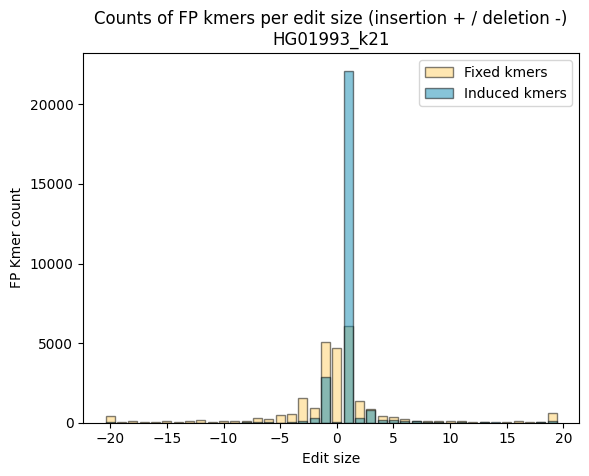

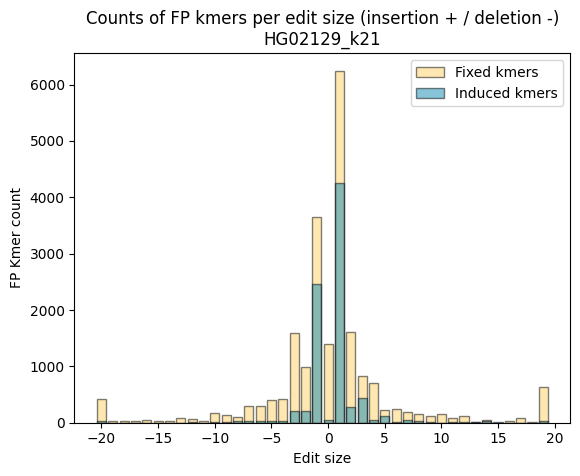

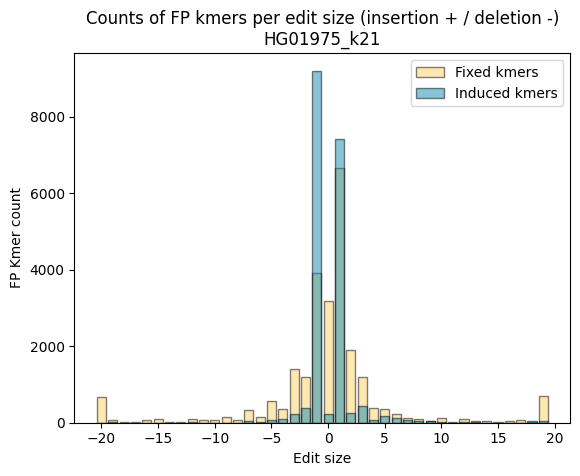

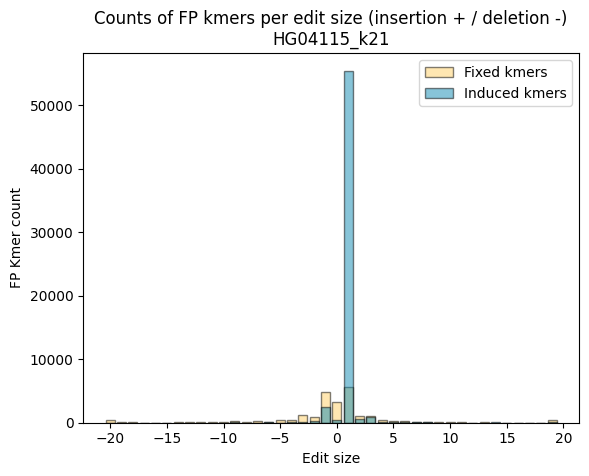

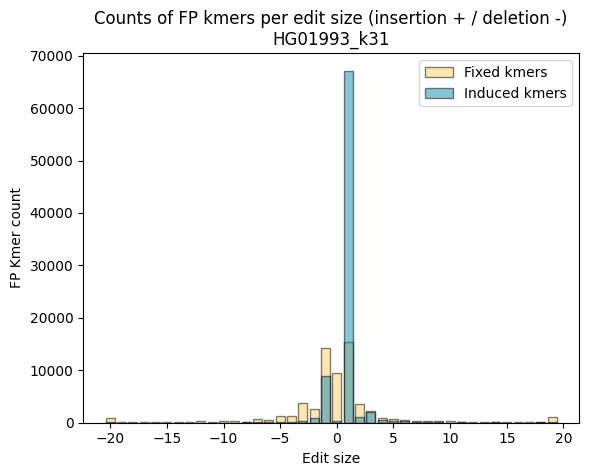

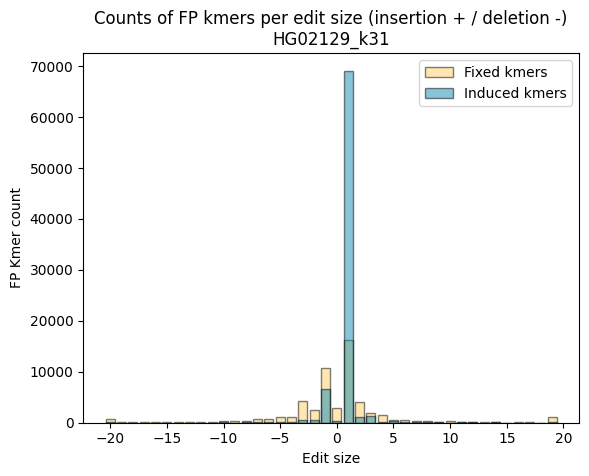

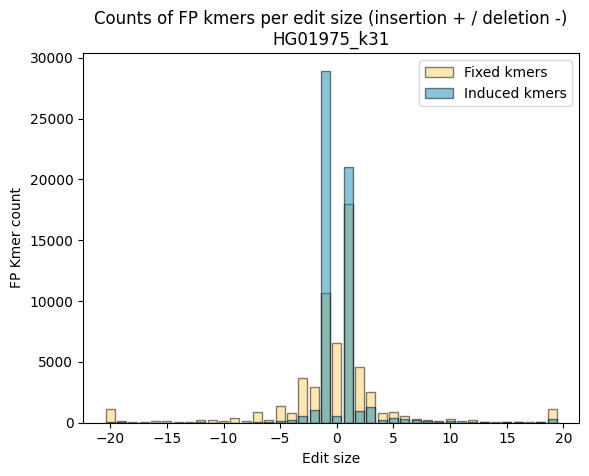

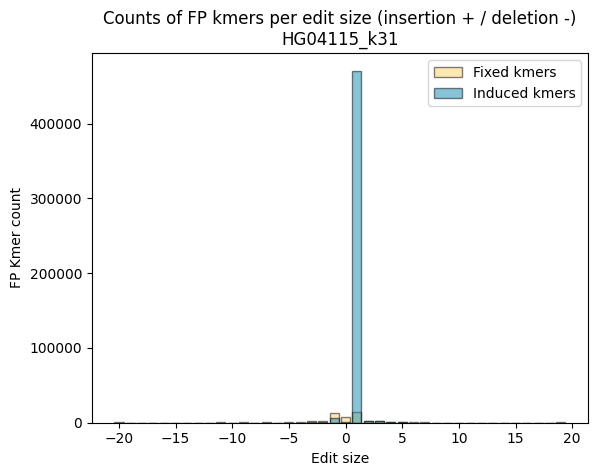

In [ ]:
# Plot counts of FP kmers per edit size
for sample in samples:

  fixed_edit_length_array, fixed_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["fixed"], max_len=20)
  induced_edit_length_array, induced_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["induced"], max_len=20)

  plt.bar(fixed_edit_length_array, fixed_kmer_edit_length_count ,  edgecolor='black', color='#ffd166', alpha=0.5,label="Fixed kmers")
  plt.bar(induced_edit_length_array, induced_kmer_edit_length_count ,  edgecolor='black', color='#118ab2', alpha=0.5,label="Induced kmers")

  plt.title(f"Counts of FP kmers per edit size (insertion + / deletion -)\n{sample}")
  plt.xlabel("Edit size")
  plt.ylabel("FP Kmer count")
  plt.legend()
  outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_per_edit_size/" + sample + ".png"
  plt.savefig(outPNG,dpi=600)
  plt.show()

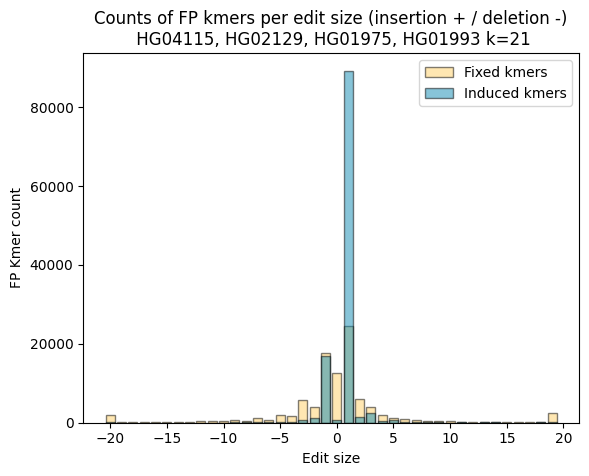

In [ ]:
# Plot counts of FP kmers per edit size for all samples combined, k=21

fixed_kmer_edit_length_count_all = np.zeros(20 * 2)
induced_kmer_edit_length_count_all = np.zeros(20 * 2)
induced_edit_length_array_all = np.arange(-20,20)
fixed_edit_length_array_all = np.arange(-20,20)

for sample in samples_k21:

  # get array of counts for each edit length, for induced and fixed
  fixed_edit_length_array, fixed_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["fixed"], max_len=20)
  induced_edit_length_array, induced_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["induced"], max_len=20)


  # check
  #print(sample,"fixed kmer edit lengths", fixed_kmer_edit_length_count[0:10])
  #print("all kmer edit lengths", fixed_kmer_edit_length_count_all[0:10])

  # add to total
  fixed_kmer_edit_length_count_all = np.add(fixed_kmer_edit_length_count_all,fixed_kmer_edit_length_count)
  induced_kmer_edit_length_count_all = np.add(induced_kmer_edit_length_count_all,induced_kmer_edit_length_count)
  #print("sum ", fixed_kmer_edit_length_count_all[0:10])

plt.bar(fixed_edit_length_array_all, fixed_kmer_edit_length_count_all ,  edgecolor='black', color='#ffd166', alpha=0.5,label="Fixed kmers")
plt.bar(induced_edit_length_array_all, induced_kmer_edit_length_count_all ,  edgecolor='black', color='#118ab2', alpha=0.5,label="Induced kmers")

plt.title(f"Counts of FP kmers per edit size (insertion + / deletion -)\n HG04115, HG02129, HG01975, HG01993 k=21")
plt.xlabel("Edit size")
plt.ylabel("FP Kmer count")
plt.legend()
outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_per_edit_size/all_samples_k21.png"
plt.savefig(outPNG,dpi=600)
plt.show()

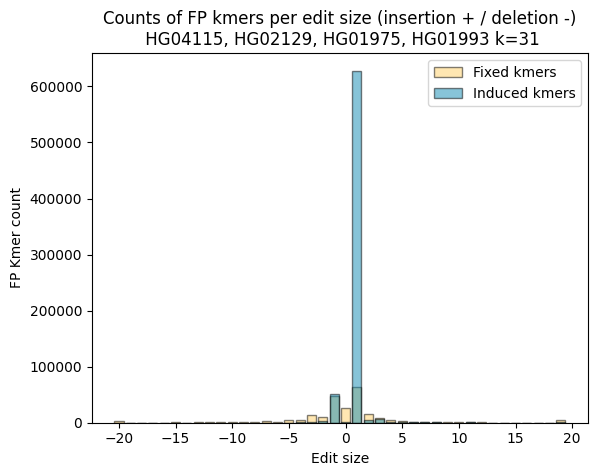

In [ ]:
# Plot counts of FP kmers per edit size for all samples combined, k=31

fixed_kmer_edit_length_count_all = np.zeros(20 * 2)
induced_kmer_edit_length_count_all = np.zeros(20 * 2)
induced_edit_length_array_all = np.arange(-20,20)
fixed_edit_length_array_all = np.arange(-20,20)

for sample in samples_k31:

  # get array of counts for each edit length, for induced and fixed
  fixed_edit_length_array, fixed_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["fixed"], max_len=20)
  induced_edit_length_array, induced_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["induced"], max_len=20)


  # check
  #print(sample,"fixed kmer edit lengths", fixed_kmer_edit_length_count[0:10])
  #print("all kmer edit lengths", fixed_kmer_edit_length_count_all[0:10])

  # add to total
  fixed_kmer_edit_length_count_all = np.add(fixed_kmer_edit_length_count_all,fixed_kmer_edit_length_count)
  induced_kmer_edit_length_count_all = np.add(induced_kmer_edit_length_count_all,induced_kmer_edit_length_count)
  #print("sum ", fixed_kmer_edit_length_count_all[0:10])

plt.bar(fixed_edit_length_array_all, fixed_kmer_edit_length_count_all ,  edgecolor='black', color='#ffd166', alpha=0.5,label="Fixed kmers")
plt.bar(induced_edit_length_array_all, induced_kmer_edit_length_count_all ,  edgecolor='black', color='#118ab2', alpha=0.5,label="Induced kmers")

plt.title(f"Counts of FP kmers per edit size (insertion + / deletion -)\n HG04115, HG02129, HG01975, HG01993 k=31")
plt.xlabel("Edit size")
plt.ylabel("FP Kmer count")
plt.legend()
outPNG="/content/drive/MyDrive/Paten_lab/polishing/DeepPolisher_Manuscript/figures/supplementary_figures_svg/FP_kmers_per_edit_size.svg"
plt.savefig(outPNG,dpi=600)
plt.show()

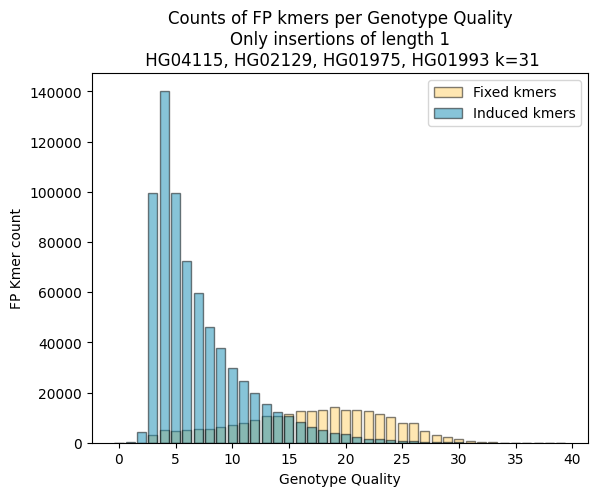

In [ ]:
# Plot counts of FP kmers per Genotype quality for all samples combined, k=31

fixed_kmer_q_count_all = np.zeros(20 * 2)
induced_kmer_q_count_all = np.zeros(20 * 2)

for sample in samples_k31:

  fixed_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  # add to total
  fixed_kmer_q_count_all = np.add(fixed_kmer_q_count_all,fixed_kmer_q_count_only_ins_one)
  induced_kmer_q_count_all = np.add(induced_kmer_q_count_all,induced_kmer_q_count_only_ins_one)

plt.bar(np.arange(40), fixed_kmer_q_count_all,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
plt.bar(np.arange(40), induced_kmer_q_count_all, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
plt.title(f"Counts of FP kmers per Genotype Quality\nOnly insertions of length 1\n HG04115, HG02129, HG01975, HG01993 k=31")
plt.xlabel("Genotype Quality")
plt.ylabel("FP Kmer count")
plt.legend()

outPNG="/content/drive/MyDrive/Paten_lab/polishing/DeepPolisher_Manuscript/figures/supplementary_figures_svg/FP_kmers_per_GQ_ins1.svg"
plt.savefig(outPNG,dpi=600)

plt.show()

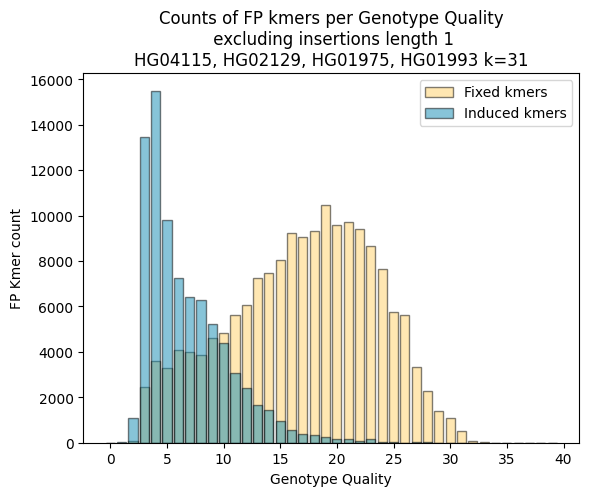

In [ ]:
# Plot counts of FP kmers per Genotype quality for all samples combined, k=31, excluding insertions 1

fixed_kmer_q_count_all = np.zeros(20 * 2)
induced_kmer_q_count_all = np.zeros(20 * 2)

for sample in samples_k31:
  fixed_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = True)
  induced_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = True)

  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  fixed_kmer_q_count_remaining =  fixed_kmer_q_count - fixed_kmer_q_count_only_ins_one
  induced_kmer_q_count_remaining = induced_kmer_q_count - induced_kmer_q_count_only_ins_one

  # add to total
  fixed_kmer_q_count_all = np.add(fixed_kmer_q_count_all,fixed_kmer_q_count_remaining)
  induced_kmer_q_count_all = np.add(induced_kmer_q_count_all,induced_kmer_q_count_remaining)

plt.bar(np.arange(40), fixed_kmer_q_count_all,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
plt.bar(np.arange(40), induced_kmer_q_count_all, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
plt.title(f"Counts of FP kmers per Genotype Quality\n excluding insertions length 1\nHG04115, HG02129, HG01975, HG01993 k=31")
plt.xlabel("Genotype Quality")
plt.ylabel("FP Kmer count")
plt.legend()

outPNG="/content/drive/MyDrive/Paten_lab/polishing/DeepPolisher_Manuscript/figures/supplementary_figures_svg/FP_kmers_per_GQ_not_ins1.svg"
plt.savefig(outPNG,dpi=600)

plt.show()

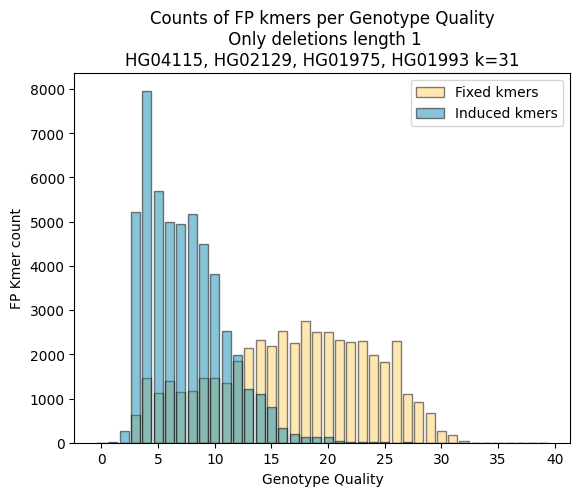

In [ ]:
# Plot counts of FP kmers per Genotype quality for all samples combined, k=31, only deletions 1

fixed_kmer_q_count_all = np.zeros(20 * 2)
induced_kmer_q_count_all = np.zeros(20 * 2)

for sample in samples_k31:
  fixed_kmer_q_count_only_del_one = get_q_count_del(vcf_dict[sample]["fixed"], only_deletion_one = True)
  induced_kmer_q_count_only_del_one = get_q_count_del(vcf_dict[sample]["induced"], only_deletion_one = True)

  # add to total
  fixed_kmer_q_count_all = np.add(fixed_kmer_q_count_all,fixed_kmer_q_count_only_del_one)
  induced_kmer_q_count_all = np.add(induced_kmer_q_count_all,induced_kmer_q_count_only_del_one)

plt.bar(np.arange(40), fixed_kmer_q_count_all,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
plt.bar(np.arange(40), induced_kmer_q_count_all, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
plt.title(f"Counts of FP kmers per Genotype Quality\n Only deletions length 1\nHG04115, HG02129, HG01975, HG01993 k=31")
plt.xlabel("Genotype Quality")
plt.ylabel("FP Kmer count")
plt.legend()

outPNG="/content/drive/MyDrive/Paten_lab/polishing/DeepPolisher_Manuscript/figures/supplementary_figures_svg/FP_kmers_per_GQ_deletions1.svg"
plt.savefig(outPNG,dpi=600)

plt.show()

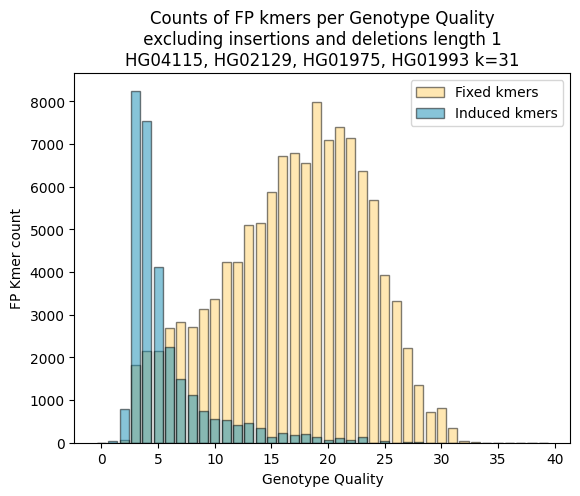

In [ ]:
#Plot counts of FP kmers per Genotype quality for all samples combined, k=31, excluding insertions 1

fixed_kmer_q_count_all = np.zeros(20 * 2)
induced_kmer_q_count_all = np.zeros(20 * 2)

for sample in samples_k31:
  fixed_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = True)
  induced_kmer_q_count_only_ins_one = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = True)

  fixed_kmer_q_count_only_del_one = get_q_count_del(vcf_dict[sample]["fixed"], only_deletion_one = True)
  induced_kmer_q_count_only_del_one = get_q_count_del(vcf_dict[sample]["induced"], only_deletion_one = True)

  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  fixed_kmer_q_count_remaining =  fixed_kmer_q_count - fixed_kmer_q_count_only_ins_one - fixed_kmer_q_count_only_del_one
  induced_kmer_q_count_remaining = induced_kmer_q_count - induced_kmer_q_count_only_ins_one - induced_kmer_q_count_only_del_one

  # add to total
  fixed_kmer_q_count_all = np.add(fixed_kmer_q_count_all,fixed_kmer_q_count_remaining)
  induced_kmer_q_count_all = np.add(induced_kmer_q_count_all,induced_kmer_q_count_remaining)

plt.bar(np.arange(40), fixed_kmer_q_count_all,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
plt.bar(np.arange(40), induced_kmer_q_count_all, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
plt.title(f"Counts of FP kmers per Genotype Quality\n excluding insertions and deletions length 1 \nHG04115, HG02129, HG01975, HG01993 k=31")
plt.xlabel("Genotype Quality")
plt.ylabel("FP Kmer count")
plt.legend()

outPNG="/content/drive/MyDrive/Paten_lab/polishing/DeepPolisher_Manuscript/figures/supplementary_figures_svg/FP_kmers_per_GQ_not_ins1_not_del1.svg"
plt.savefig(outPNG,dpi=600)

plt.show()

In [ ]:
## Does the 1bp insertions go away with hybrid kmers?

samples_hybrid = [ "HG04115_hybrid_k21", "HG04115_hybrid_k31"]

vcf_dict = {}
base_path = "/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_annotated_vcfs"
for sample in samples_hybrid:
  vcf_dict[sample] = {}
  vcf_dict[sample]["fixed"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_fixed_fp_kmers.vcf")
  vcf_dict[sample]["induced"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_induced_fp_kmers.vcf")

In [ ]:
vcf_dict["HG04115_hybrid_k21"]["fixed"][0]

['h1tg000001l',
 '10237828',
 '.',
 'T',
 'TG',
 '25',
 'PASS',
 '.',
 'GT:GQ',
 '0/1:25',
 'h1tg000001l',
 '10237809',
 '10237848',
 '19']

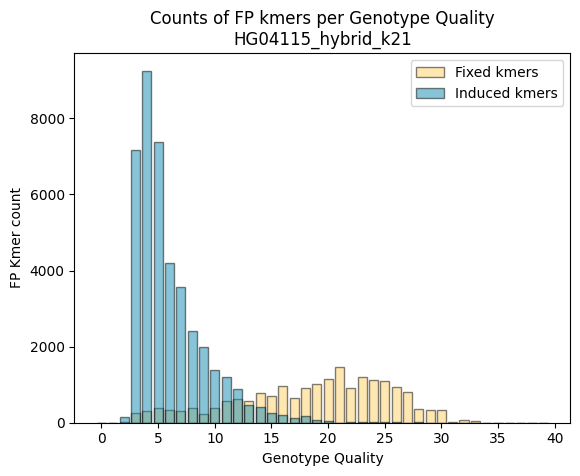

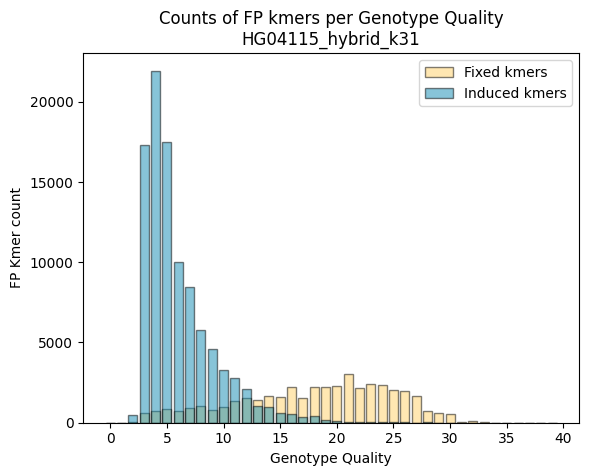

In [ ]:
for sample in samples_hybrid:
  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  # Plotting a basic histogram
  plt.bar(np.arange(40), fixed_kmer_q_count,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(40), induced_kmer_q_count, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\n{sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()


  outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_GQ_plots/" + sample + ".all_edits.png"
  plt.savefig(outPNG,dpi=600)
  plt.show()

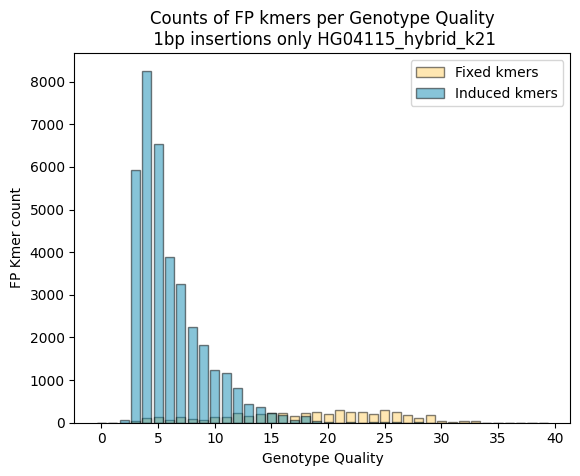

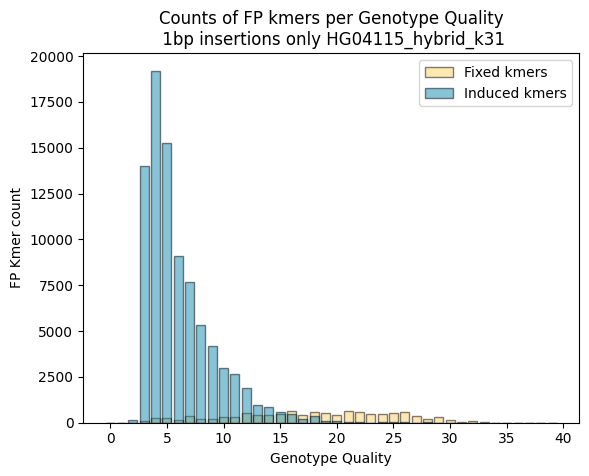

In [ ]:
for sample in samples_hybrid:
  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = True)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = True)

  # Plotting a basic histogram
  plt.bar(np.arange(40), fixed_kmer_q_count,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(40), induced_kmer_q_count, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\n 1bp insertions only {sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()


  outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_GQ_plots/" + sample + ".ins1.png"
  plt.savefig(outPNG,dpi=600)
  plt.show()

-22085.0


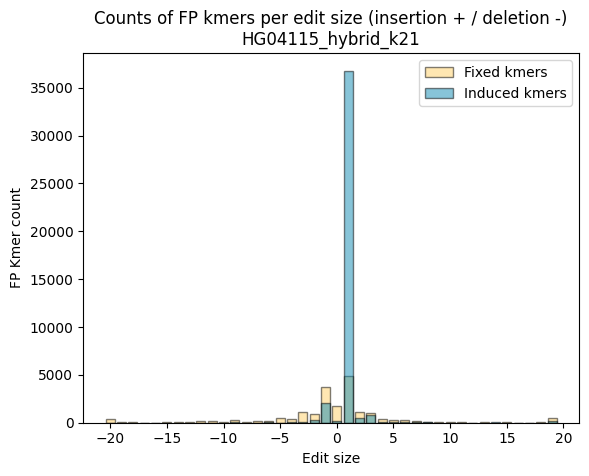

-56059.0


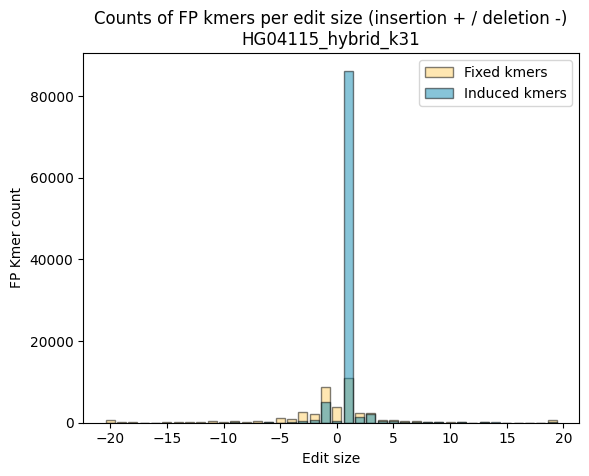

In [ ]:
# Plot counts of FP kmers per edit size
for sample in samples_hybrid:

  fixed_edit_length_array, fixed_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["fixed"], max_len=20)
  induced_edit_length_array, induced_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["induced"], max_len=20)

  print(sum(fixed_kmer_edit_length_count)-sum(induced_kmer_edit_length_count))
  plt.bar(fixed_edit_length_array, fixed_kmer_edit_length_count ,  edgecolor='black', color='#ffd166', alpha=0.5,label="Fixed kmers")
  plt.bar(induced_edit_length_array, induced_kmer_edit_length_count ,  edgecolor='black', color='#118ab2', alpha=0.5,label="Induced kmers")

  plt.title(f"Counts of FP kmers per edit size (insertion + / deletion -)\n{sample}")
  plt.xlabel("Edit size")
  plt.ylabel("FP Kmer count")
  plt.legend()
  outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/fp_kmer_per_edit_size/" + sample + ".png"
  plt.savefig(outPNG,dpi=600)
  plt.show()